In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
lap_data = pd.read_csv("./datasets/lapdata/Bahrain_Grand_Prix.csv")
telem_data = pd.read_csv("./datasets/telemetry_data/Bahrain_time_series.csv")

In [55]:
driver_id = "VER"

### Lap data analysis

In [56]:
driver_laps = lap_data.loc[lap_data["Driver"] == driver_id]
driver_race_time = pd.to_datetime(driver_laps["LapTime"].sum(), unit="s").time()
print(driver_race_time)
print(driver_laps.head())

01:31:44.741999
   DriverNumber Driver  LapNumber Compound  TyreLife  Sector1Time  \
0             1    VER        1.0     SOFT       4.0          NaN   
1             1    VER        2.0     SOFT       5.0       30.916   
2             1    VER        3.0     SOFT       6.0       30.999   
3             1    VER        4.0     SOFT       7.0       30.931   
4             1    VER        5.0     SOFT       8.0       31.255   

   Sector2Time  Sector3Time  LapTime  
0       41.266       23.616   97.284  
1       41.661       23.719   96.296  
2       41.966       23.788   96.753  
3       41.892       23.824   96.647  
4       42.056       23.862   97.173  


Text(0.5, 1.0, 'Driver lap times')

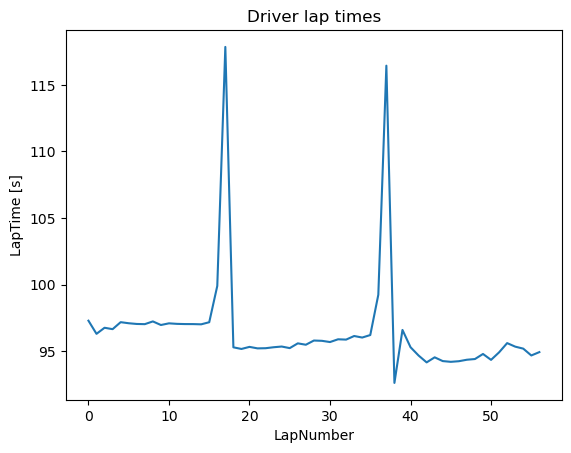

In [6]:
plt.figure()
plt.plot(np.arange(len(driver_laps)), driver_laps["LapTime"])
plt.xlabel("LapNumber")
plt.ylabel("LapTime [s]")
plt.title("Driver lap times")

### Telemetry data analysis

In [25]:
print(telem_data.head())
driver_telemetry = telem_data.loc[telem_data["Driver"] == driver_id] \
        [["Date", "RPM", "Speed", "nGear", "Throttle", "Brake", "DRS", "LapNumber"]]

driver_telemetry = driver_telemetry \
            .set_index(pd.to_datetime(driver_telemetry["Date"])).drop(["Date"], axis=1)

driver_telemetry.head(n=10)

                      Date   RPM  Speed  nGear  Throttle  Brake  DRS  \
0  2024-03-02 15:03:42.342  9973      0      1        15   True    1   
1  2024-03-02 15:03:42.390  9963      0      1        15   True    1   
2  2024-03-02 15:03:42.460  9859      0      1        15   True    1   
3  2024-03-02 15:03:42.630  9755      0      1        15   True    1   
4  2024-03-02 15:03:42.700  9125      1      1        15   True    1   

                     Time             SessionTime  DriverAhead  \
0         0 days 00:00:00  0 days 00:59:59.911000          NaN   
1  0 days 00:00:00.048000  0 days 00:59:59.959000          NaN   
2  0 days 00:00:00.118000  0 days 01:00:00.029000          NaN   
3  0 days 00:00:00.288000  0 days 01:00:00.199000          3.0   
4  0 days 00:00:00.358000  0 days 01:00:00.269000          3.0   

   DistanceToDriverAhead           X            Y  LapNumber  TrackStatus  \
0               0.133333 -279.998940  3550.093709        1.0           12   
1               

,RPM,Speed,nGear,Throttle,Brake,DRS,LapNumber
Date,,,,,,,
2024-03-02 15:03:42.342,9973,0,1,15,True,1,1.0
2024-03-02 15:03:42.390,9963,0,1,15,True,1,1.0
2024-03-02 15:03:42.460,9859,0,1,15,True,1,1.0
2024-03-02 15:03:42.630,9755,0,1,15,True,1,1.0
2024-03-02 15:03:42.700,9125,1,1,15,True,1,1.0
2024-03-02 15:03:42.870,8495,3,1,15,False,1,1.0
2024-03-02 15:03:43.040,7655,7,1,15,False,1,1.0
2024-03-02 15:03:43.110,6815,11,1,15,False,1,1.0
2024-03-02 15:03:43.270,5695,17,1,15,False,1,1.0


Text(0.5, 1.0, 'Timeseries data sampling step')

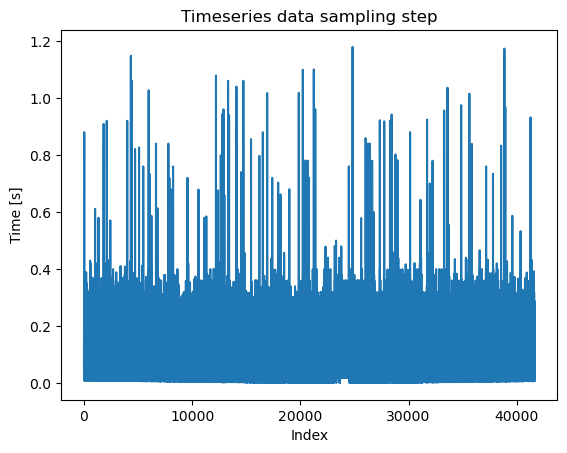

In [8]:
########### Check data sampling step ###########
DT = (driver_telemetry.index[1:] - driver_telemetry.index[:-1]).total_seconds()
plt.plot(np.arange(len(driver_telemetry.index[:-1])), DT)
plt.ylabel("Time [s]")
plt.xlabel("Index")
plt.title("Timeseries data sampling step")

               Speed  Acceleration
LapNumber                         
1.0        52.393925      7.033798
2.0        55.929531      6.488901
3.0        55.434654      6.567381
4.0        55.404339      6.634168
5.0        55.204042      6.586330


Text(0.5, 1.0, 'Car acceleration by lap')

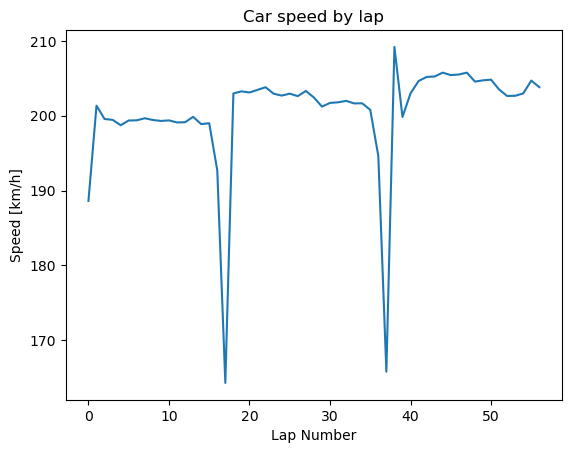

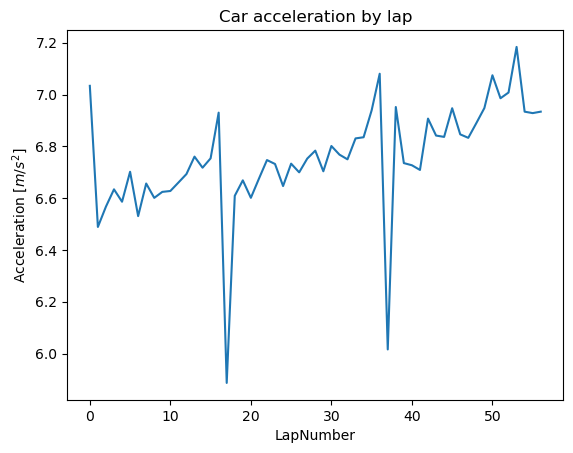

In [9]:
car_data = pd.DataFrame(
    {
        "Speed": driver_telemetry["Speed"].values / 3.6, # convert from km/h to m/s
        "LapNumber": driver_telemetry["LapNumber"].values
    },
    index = driver_telemetry.index
)

########### Resample and aggregate selected data ###########

downsampled_groups = []
for lap, lap_data in car_data.groupby('LapNumber'):
    lap_downsampled = lap_data.resample('1S').agg({
        'Speed': 'mean',
        'LapNumber': 'first'
    })
    
    downsampled_groups.append(lap_downsampled)

resampled_car_data = pd.concat(downsampled_groups).sort_index()

########### Calculate car acceleration ###########

dt = 1.0
acceleration = abs(resampled_car_data["Speed"].values[1:] - resampled_car_data["Speed"].values[:-1]) / dt
acceleration = np.insert(acceleration, 0, 0.0)
resampled_car_data["Acceleration"] = acceleration


########### Calculate and display car mean velocity and acceleration by lap ###########

car_data_by_lap = resampled_car_data.groupby("LapNumber").mean()
print(car_data_by_lap.head())

plt.figure()
plt.plot(np.arange(len(car_data_by_lap["Speed"])), car_data_by_lap["Speed"].values * 3.6)
plt.xlabel("Lap Number")
plt.ylabel("Speed [km/h]")
plt.title("Car speed by lap")
plt.figure()
plt.plot(np.arange(len(car_data_by_lap["Acceleration"])), car_data_by_lap["Acceleration"].values)
plt.xlabel("LapNumber")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.title("Car acceleration by lap")

Text(0.5, 1.0, 'Car engine force by lap')

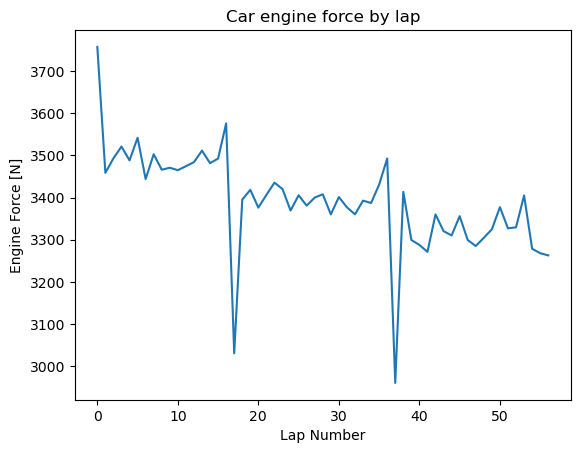

In [10]:
########### Calculate and display mean car engine force by lap ###########

m_car = 798
m_fuel = 110
mu = 1.7

n_laps = len(car_data_by_lap)
m_total = m_car + m_fuel
fuel_consumption = m_fuel / n_laps # Linear fuel consuption by each lap

engine_force_data = []
for accel in car_data_by_lap["Acceleration"].values:
    engine_force_data.append((m_total * accel) / mu)
    m_fuel -= fuel_consumption
    m_total = m_car + m_fuel

car_data_by_lap["EngineForce"] = engine_force_data

plt.figure()
plt.plot(np.arange(len(car_data_by_lap["EngineForce"])), car_data_by_lap["EngineForce"].values)
plt.xlabel("Lap Number")
plt.ylabel("Engine Force [N]")
plt.title("Car engine force by lap")


Text(0.5, 1.0, 'Friction by lap')

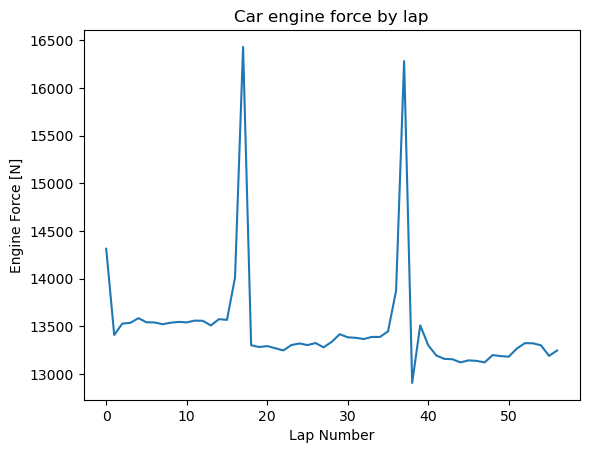

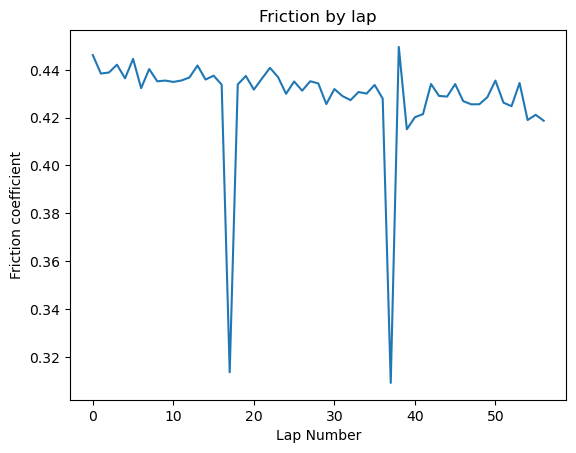

In [11]:
########### Calculate and display mean car engine force by lap ###########

m_car = 798
m_fuel = 110
mu = 1.7
red_bull_car_power = 750000 # In Watts

car_data_by_lap["EngineForce"] = red_bull_car_power / car_data_by_lap["Speed"]

m_total = m_car + m_fuel
fuel_consumption = m_fuel / len(car_data_by_lap) # Linear fuel consuption by each lap

car_friction_data = []
for accel, engine_force in zip(car_data_by_lap["Acceleration"].values, car_data_by_lap["EngineForce"].values):
    car_friction_data.append((m_total * accel) / engine_force)
    m_fuel -= fuel_consumption
    m_total = m_car + m_fuel

car_data_by_lap["FrictionCoeff"] = car_friction_data

plt.figure()
plt.plot(np.arange(len(car_data_by_lap["EngineForce"])), car_data_by_lap["EngineForce"].values)
plt.xlabel("Lap Number")
plt.ylabel("Engine Force [N]")
plt.title("Car engine force by lap")
plt.figure()
plt.plot(np.arange(len(car_data_by_lap["FrictionCoeff"])), car_data_by_lap["FrictionCoeff"].values)
plt.xlabel("Lap Number")
plt.ylabel("Friction coefficient")
plt.title("Friction by lap")


### Japan GP track analysis

In [144]:
telem_data = pd.read_csv("./datasets/telemetry_data/Japan_time_series.csv")
telem_data.head()

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Time,SessionTime,DriverAhead,DistanceToDriverAhead,X,Y,LapNumber,TrackStatus,DriverNumber,Driver,ID
0,2024-04-07 05:03:42.056,10043,0,1,16,True,1,0 days 00:00:00,0 days 01:02:40.422000,NaN,0.111111,3513,-2962,1.0,125,1,VER,0
1,2024-04-07 05:03:42.122,10043,0,1,16,True,1,0 days 00:00:00.066000,0 days 01:02:40.488000,NaN,0.111111,3514,-2963,1.0,125,1,VER,1
2,2024-04-07 05:03:42.244,10044,0,1,16,True,1,0 days 00:00:00.188000,0 days 01:02:40.610000,NaN,0.111111,3514,-2963,1.0,125,1,VER,2
3,2024-04-07 05:03:42.322,9499,0,1,16,True,1,0 days 00:00:00.266000,0 days 01:02:40.688000,NaN,0.111111,3514,-2963,1.0,125,1,VER,3
4,2024-04-07 05:03:42.542,8954,0,1,16,True,1,0 days 00:00:00.486000,0 days 01:02:40.908000,NaN,0.111111,3514,-2963,1.0,125,1,VER,4


      X     Y  LapNumber
0  3513 -2962        1.0
1  3514 -2963        1.0
2  3514 -2963        1.0
3  3514 -2963        1.0
4  3514 -2963        1.0


Text(0.5, 1.0, 'Japan GP')

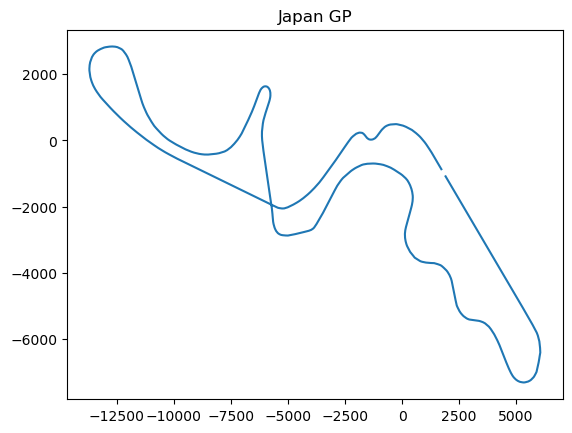

In [ ]:
position_data = telem_data.loc[telem_data["Driver"] == "VER"] \
            [["X", "Y", "LapNumber"]]

track_curve = position_data.loc[position_data["LapNumber"] == 15.0]

plt.plot(track_curve["X"].values, track_curve["Y"].values)
#plt.gca().invert_xaxis()
plt.title("Japan GP")

Curvature: 0.041650929367741764


/tmp/ipykernel_33974/2427134519.py:4: RuntimeWarning: divide by zero encountered in divide
  first_derivatives = dy / dx


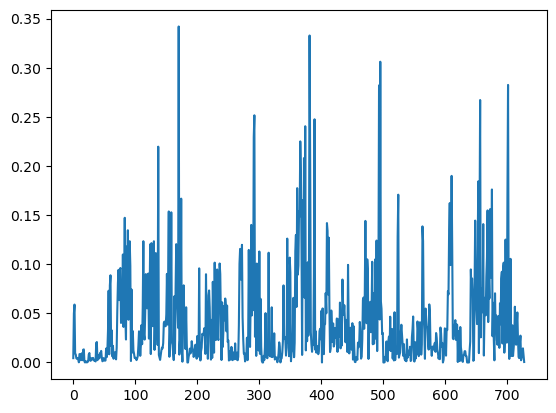

In [164]:
dx = np.diff(track_curve["X"].values)
dy = np.diff(track_curve["Y"].values)

first_derivatives = dy / dx

second_derivatives = np.diff(first_derivatives)

with np.errstate(divide='ignore', invalid='ignore'):
    curvature = np.abs(second_derivatives) / (1 + first_derivatives[:-1]**2)**(3/2)

curvature = np.nan_to_num(curvature, nan=0.0, posinf=0.0, neginf=0.0)

plt.plot(np.arange(len(curvature)), curvature)
print(f"Curvature: {np.mean(curvature)}")